<a href="https://colab.research.google.com/github/Pepe-Padilla/deep-learning/blob/main/Modelo1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo1D - DeepLearning


### Indice
1. Introducción
2. Importación y Normalización de datos
3. Entrenamiento
4. Gráfica de Perdidas
5. Test
6. Concluciones

##  1. Introducción

**Práctica DL** - Ejercicio de Bootcamp Inteligencia Artificial Full Stack Edición III

Este proyecto es un entregable para la práctica del Master Bootcamp Inteligencia Artificial Full Stack Edición III realizado por el centro de formación [@Keepcoding](https://github.com/KeepCoding)

---

El objetivo de este trabajo consiste en resolver un problema del mundo real empleando para ello técnicas vistas durante las sesiones de dicho módulo. En concreto, se trabajará en predecir la condición médica sufrida por una cohorte de pacientes a partir de las diferentes fuentes de información disponibles (imágenes y datos tabulares).

Las imagenes deben entrenar y obtener una de los siguientes respuestas:

| Enfermedad | Descripción | Código | Indice en salida |
|------------|-------------|--------|------------------|
| Actinic keratoses y carcinoma de células escamosas | Tipo de cáncer de piel | akiec | 0 |
| Nevus melanocítico | Lesión benigna común | nv | 1 |
| Melanoma | Tipo de cáncer de piel agresivo | mel | 2 |
| Lesiones benignas de queratosis | Incluyen lentigo solar y queratosis seborreica | bkl | 3 |
| Dermatofibroma | Lesión benigna del tejido fibroso | df | 4 |
| Vasculares | Lesiones vasculares como hemangiomas | vasc | 5 |
| Lesión de células basales | Un tipo de cáncer de piel menos agresivo que el melanoma | bcc | 6 |

---



## 2. Importación y Normalización de datos

### 2.1 Imports

In [46]:
# 1. Primero las importaciones que necesitaremos
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

### 2.2 Obtención de datos

In [47]:
# 2. Obtención de datos
#dataframe = pd.read_csv("/content/HAM10000_metadata.csv", usecols=[1], engine='python', skipfooter=3)
#df = dataframe.values
df = pd.read_csv("/content/HAM10000_metadata.csv", sep=",")


### 2.3 Inspección de elementos

In [48]:
# 3. Inspeccionamos y normalización
print(df.head())
print(df.info())
print(df.describe())

# Primero busquemos nulls en las columnas que valgan la pena
print(df.isnull().sum())

# Solo age tiene null, solo se me ocurre rellenar con la mediana
df["age"] = df["age"].fillna(df["age"].median())
df['age'] = df['age'] / 100  # Escalamos considerando 100 como el máximo teórico

# para evitar problemas después, convertir el tipo de age a un float compatible para Tensor
df['age'] = df['age'].astype('float32')

# Convertimos las variables 'sex' y 'localization' a categorías one-hot encoding
df = pd.get_dummies(df, columns=['sex', 'localization','dx'])


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None
               age
count  9958.000000
mean  

In [50]:
print(df.head())
print(df.info())
print(df.describe())

     lesion_id      image_id dx_type   age  sex_female  sex_male  sex_unknown  \
0  HAM_0000118  ISIC_0027419   histo  0.80       False      True        False   
1  HAM_0000118  ISIC_0025030   histo  0.80       False      True        False   
2  HAM_0002730  ISIC_0026769   histo  0.80       False      True        False   
3  HAM_0002730  ISIC_0025661   histo  0.80       False      True        False   
4  HAM_0001466  ISIC_0031633   histo  0.75       False      True        False   

   localization_abdomen  localization_acral  localization_back  ...  \
0                 False               False              False  ...   
1                 False               False              False  ...   
2                 False               False              False  ...   
3                 False               False              False  ...   
4                 False               False              False  ...   

   localization_trunk  localization_unknown  localization_upper extremity  \
0        

### 2.4 Separación de datos

In [52]:
# 4. Separamos datos
dropX = ['lesion_id','image_id','dx_akiec','dx_bcc','dx_bkl','dx_df','dx_mel','dx_nv','dx_vasc','dx_type']
dropY = ['lesion_id','image_id','dx_type','age','sex_female','sex_male','sex_unknown','localization_abdomen','localization_acral','localization_back','localization_chest','localization_ear',
  'localization_face','localization_foot','localization_genital','localization_hand','localization_lower extremity',
  'localization_neck','localization_scalp','localization_trunk','localization_unknown','localization_upper extremity']
x = df.drop(dropX, axis=1).astype(np.float32).values  # Convertimos todo a float32
y = df.drop(dropY, axis=1).astype(np.float32).values  # Convertimos todo a float32

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=True, test_size=0.15)

### 2.5 Verificación

In [59]:
# 5. Verificación de normalización
x_traindf = pd.DataFrame(x_train)
y_traindf = pd.DataFrame(y_train)

print(x_traindf.describe())
print(y_traindf.describe())
print(x_traindf.shape)

                0            1            2            3           4   \
count  6810.000000  6810.000000  6810.000000  6810.000000  6810.00000   
mean      0.517790     0.459471     0.535095     0.005433     0.10279   
std       0.169512     0.498372     0.498818     0.073513     0.30370   
min       0.000000     0.000000     0.000000     0.000000     0.00000   
25%       0.400000     0.000000     0.000000     0.000000     0.00000   
50%       0.500000     0.000000     1.000000     0.000000     0.00000   
75%       0.650000     1.000000     1.000000     0.000000     0.00000   
max       0.850000     1.000000     1.000000     1.000000     1.00000   

                5            6            7            8            9   \
count  6810.000000  6810.000000  6810.000000  6810.000000  6810.000000   
mean      0.000734     0.216446     0.040382     0.006021     0.073275   
std       0.027088     0.411865     0.196869     0.077365     0.260609   
min       0.000000     0.000000     0.000000  

## 3. Entrenamiento

In [55]:
# Imports necesarios
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Hiper-parámetros de nuestra red
lr = 0.005
n_epochs = 50
batch_size = 128

# Implementamos la red empleando Keras
model = Sequential() # Instancia de modelo API secuencial
model.add(Flatten()) # Estiramos los datos en forma de vector como entrada a nuestro Perceptrón Simple
model.add(Dense(7, input_shape=(19,), activation="softmax")) # Construimos nuestro Perceptrón simple con una única capa Dense

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr), metrics=["accuracy"])

H = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, batch_size=batch_size)

# Evaluando el modelo de predicción
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(x_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))



[INFO]: Entrenando red neuronal...
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2034 - loss: 1.8539 - val_accuracy: 0.5316 - val_loss: 1.7509
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5531 - loss: 1.7154 - val_accuracy: 0.5483 - val_loss: 1.6356
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5978 - loss: 1.5990 - val_accuracy: 0.6306 - val_loss: 1.5437
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6694 - loss: 1.4943 - val_accuracy: 0.6514 - val_loss: 1.4716
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6689 - loss: 1.4452 - val_accuracy: 0.6547 - val_loss: 1.4161
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6755 - loss: 1.3813 - val_accuracy: 0.6547 - val_loss: 1.3735
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6659 - loss: 1.3537 - val_accuracy: 0.6547 - val_loss: 1.3409
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6635 - loss: 1.3215

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Gráfica de Perdidas

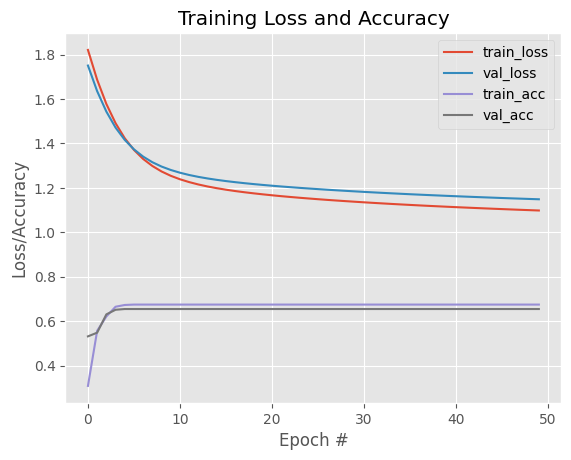

In [56]:
# veamos nuestra función de pérdidas con respecto a las épocas ejecutadas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## 5. Concluciones

Aquí van mis concluciones